<a href="https://colab.research.google.com/github/ARCHISHMANx01/helloy-word/blob/master/Infectious_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'infectious-disease-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F775512%2F1335435%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240927%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240927T210515Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dce1fd018b5884722331880d43ec782cb9a4c1b4173025b86472bac87473c4c7a1514b2a2ba96d226e93499a4841b3f1341ffcb1b69b681d074e617ac5b1ad1c13b7b0b700e28812d95ac9256808fcd37060f8622ef03c0b85935dae410fd1114fb35e434b715a8b6acbb75ebce80dd754db939ddc99092e3fd3872e4459e3de4927a735a6ed657b2d7f4f55080dbdf588802ea8b37dfa191d7d80deae3d24a89fdf2da8606ad00a28bd596b81133842e179dcf66ee6c1c0f03292942c659fbc70e0ca3d9d5954f5ec78dac2a849b887b10835453ad33ff97798098ba64a73dcc755c24546dde71f485dd037d383f56f75e015a34f30358ddf940e4af324eaf5a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1804291 bytes downloaded
Downloaded and uncompressed: infectious-disease-prediction
Data source import complete.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/infectious-disease-prediction/train.csv
/kaggle/input/infectious-disease-prediction/test.csv


In [3]:
train_df = pd.read_csv("/kaggle/input/infectious-disease-prediction/train.csv")
test_df = pd.read_csv("/kaggle/input/infectious-disease-prediction/test.csv")
test_df[test_df["Year"] == 2001].head()

,Unnamed: 0,Disease,County,Year,Sex,Count,Population,Rate,CI.lower,CI.upper
0,3364,Anaplasmosis and Ehrlichiosis,Marin,2001,Female,0,125414,0.000,0.000,2.941
2,8922,"Botulism, Foodborne",San Benito,2001,Male,0,27611,0.000,0.000,13.359
23,53321,Gonorrhea,Yolo,2001,Male,20,85447,23.406,14.298,36.147
52,32201,Cryptosporidiosis,Merced,2001,Female,0,108778,0.000,0.000,3.391
62,43965,E. coli O157,Stanislaus,2001,Female,6,235061,2.553,0.937,5.556


In [4]:
#df.sort_values("Rate", ascending = False).head()
#train_df.isna().sum()
#test_df.isna().sum()
#train_df.info()
df = pd.concat([train_df, test_df]).drop("Unnamed: 0", axis = 1)

In [5]:
#pd.set_option('display.max_seq_items', None)
#pd.set_option('display.max_rows', None)
disease_categories = {
    'Amebiasis': 'Parasitic Infections',
    'Anaplasmosis and Ehrlichiosis': 'Bacterial Infections',
    'Babesiosis': 'Parasitic Infections',
    'Botulism, Foodborne': 'Bacterial Infections',
    'Botulism, Other': 'Bacterial Infections',
    'Botulism, Wound': 'Bacterial Infections',
    'Brucellosis': 'Bacterial Infections',
    'Campylobacteriosis': 'Bacterial Infections',
    'Chlamydia': 'Bacterial Infections',
    'Cholera': 'Bacterial Infections',
    'Ciguatera Fish Poisoning': 'Toxin-Related Conditions',
    'Coccidioidomycosis': 'Fungal Infections',
    'Creutzfeldt-Jakob Disease and other Transmissible Spongiform Encephalopathies': 'Other',
    'Cryptosporidiosis': 'Parasitic Infections',
    'Cyclosporiasis': 'Parasitic Infections',
    'Cysticercosis or Taeniasis': 'Parasitic Infections',
    'Dengue': 'Viral Infections',
    'Diphtheria': 'Bacterial Infections',
    'E. coli O157': 'Bacterial Infections',
    'E. coli Other STEC (non-O157)': 'Bacterial Infections',
    'Early Syphilis': 'Bacterial Infections',
    'Giardiasis': 'Parasitic Infections',
    'Gonorrhea': 'Bacterial Infections',
    'HIV': 'Viral Infections',
    'Hantavirus Infection': 'Viral Infections',
    'Hemolytic Uremic Syndrome': 'Other',
    'Hepatitis A': 'Viral Infections',
    'Hepatitis B, Acute': 'Viral Infections',
    'Hepatitis C, Acute': 'Viral Infections',
    'Hepatitis E, acute infection': 'Viral Infections',
    'Influenza Death (<65 years of age)': 'Viral Infections',
    'Invasive Meningococcal Disease': 'Bacterial Infections',
    'Legionellosis': 'Bacterial Infections',
    'Leprosy': 'Bacterial Infections',
    'Leptospirosis': 'Bacterial Infections',
    'Listeriosis': 'Bacterial Infections',
    'Lyme Disease': 'Bacterial Infections',
    'Malaria': 'Parasitic Infections',
    'Measles': 'Viral Infections',
    'Mumps': 'Viral Infections',
    'Paralytic Shellfish Poisoning': 'Toxin-Related Conditions',
    'Pertussis': 'Bacterial Infections',
    'Plague, human': 'Bacterial Infections',
    'Psittacosis': 'Bacterial Infections',
    'Q Fever': 'Bacterial Infections',
    'Rabies, human': 'Viral Infections',
    'Relapsing Fever': 'Bacterial Infections',
    'Rubella': 'Viral Infections',
    'Salmonellosis': 'Bacterial Infections',
    'Scombroid Fish Poisoning': 'Toxin-Related Conditions',
    'Shiga Toxin Positive Feces (without culture confirmation)': 'Other',
    'Shigellosis': 'Bacterial Infections',
    'Spotted Fever Rickettsiosis': 'Bacterial Infections',
    'Staphylococcus aureus Infection (cases resulting in death or ICU)': 'Bacterial Infections',
    'Streptococcal Infection (cases in food and dairy workers)': 'Bacterial Infections',
    'Tetanus': 'Bacterial Infections',
    'Toxic Shock Syndrome (Non-Streptococcal)': 'Other',
    'Trichinosis': 'Parasitic Infections',
    'Tuberculosis': 'Bacterial Infections',
    'Tularemia': 'Bacterial Infections',
    'Typhoid Fever, case': 'Bacterial Infections',
    'Typhus Fever': 'Bacterial Infections',
    'Varicella Hospitalizations': 'Viral Infections',
    'Vibrio Infection (non-Cholera)': 'Bacterial Infections',
    'Yersiniosis': 'Bacterial Infections'
}
disease_symptom_mapping = {
    'Amebiasis': 'Gastrointestinal',
    'Anaplasmosis and Ehrlichiosis': 'Systemic',
    'Babesiosis': 'Systemic',
    'Botulism, Foodborne': 'Neurological',
    'Botulism, Other': 'Neurological',
    'Botulism, Wound': 'Neurological',
    'Brucellosis': 'Systemic',
    'Campylobacteriosis': 'Gastrointestinal',
    'Chlamydia': 'Other',
    'Cholera': 'Gastrointestinal',
    'Ciguatera Fish Poisoning': 'Neurological',
    'Coccidioidomycosis': 'Respiratory',
    'Creutzfeldt-Jakob Disease and other Transmissible Spongiform Encephalopathies': 'Neurological',
    'Cryptosporidiosis': 'Gastrointestinal',
    'Cyclosporiasis': 'Gastrointestinal',
    'Cysticercosis or Taeniasis': 'Neurological',
    'Dengue': 'Systemic',
    'Diphtheria': 'Respiratory',
    'E. coli O157': 'Gastrointestinal',
    'E. coli Other STEC (non-O157)': 'Gastrointestinal',
    'Early Syphilis': 'Skin/Soft Tissue',
    'Giardiasis': 'Gastrointestinal',
    'Gonorrhea': 'Other',
    'HIV': 'Systemic',
    'Hantavirus Infection': 'Respiratory',
    'Hemolytic Uremic Syndrome': 'Systemic',
    'Hepatitis A': 'Gastrointestinal',
    'Hepatitis B, Acute': 'Gastrointestinal',
    'Hepatitis C, Acute': 'Gastrointestinal',
    'Hepatitis E, acute infection': 'Gastrointestinal',
    'Influenza Death (<65 years of age)': 'Respiratory',
    'Invasive Meningococcal Disease': 'Neurological',
    'Legionellosis': 'Respiratory',
    'Leprosy': 'Skin/Soft Tissue',
    'Leptospirosis': 'Systemic',
    'Listeriosis': 'Gastrointestinal',
    'Lyme Disease': 'Skin/Soft Tissue',
    'Malaria': 'Systemic',
    'Measles': 'Skin/Soft Tissue',
    'Mumps': 'Systemic',
    'Paralytic Shellfish Poisoning': 'Neurological',
    'Pertussis': 'Respiratory',
    'Plague, human': 'Systemic',
    'Psittacosis': 'Respiratory',
    'Q Fever': 'Systemic',
    'Rabies, human': 'Neurological',
    'Relapsing Fever': 'Systemic',
    'Rubella': 'Skin/Soft Tissue',
    'Salmonellosis': 'Gastrointestinal',
    'Scombroid Fish Poisoning': 'Neurological',
    'Shiga Toxin Positive Feces (without culture confirmation)': 'Gastrointestinal',
    'Shigellosis': 'Gastrointestinal',
    'Spotted Fever Rickettsiosis': 'Skin/Soft Tissue',
    'Staphylococcus aureus Infection (cases resulting in death or ICU)': 'Skin/Soft Tissue',
    'Streptococcal Infection (cases in food and dairy workers)': 'Skin/Soft Tissue',
    'Tetanus': 'Neurological',
    'Toxic Shock Syndrome (Non-Streptococcal)': 'Systemic',
    'Trichinosis': 'Neurological',
    'Tuberculosis': 'Respiratory',
    'Tularemia': 'Systemic',
    'Typhoid Fever, case': 'Gastrointestinal',
    'Typhus Fever': 'Systemic',
    'Varicella Hospitalizations': 'Skin/Soft Tissue',
    'Vibrio Infection (non-Cholera)': 'Gastrointestinal',
    'Yersiniosis': 'Gastrointestinal'
}
disease_mapping = {
    'Amebiasis': 'Amebiasis',
    'Anaplasmosis and Ehrlichiosis': 'Anaplasmosis and Ehrlichiosis',
    'Babesiosis': 'Babesiosis',
    'Botulism, Foodborne': 'Botulism',
    'Botulism, Other': 'Botulism',
    'Botulism, Wound': 'Botulism',
    'Brucellosis': 'Brucellosis',
    'Campylobacteriosis': 'Campylobacteriosis',
    'Chlamydia': 'Chlamydia',
    'Cholera': 'Cholera',
    'Ciguatera Fish Poisoning': 'Fish Poisoning',
    'Coccidioidomycosis': 'Coccidioidomycosis',
    'Creutzfeldt-Jakob Disease and other Transmissible Spongiform Encephalopathies': 'Creutzfeldt-Jakob Disease',
    'Cryptosporidiosis': 'Cryptosporidiosis',
    'Cyclosporiasis': 'Cyclosporiasis',
    'Cysticercosis or Taeniasis': 'Cysticercosis or Taeniasis',
    'Dengue': 'Dengue',
    'Diphtheria': 'Diphtheria',
    'E. coli O157': 'E. coli',
    'E. coli Other STEC (non-O157)': 'E. coli',
    'Early Syphilis': 'Syphilis',
    'Giardiasis': 'Giardiasis',
    'Gonorrhea': 'Gonorrhea',
    'HIV': 'HIV',
    'Hantavirus Infection': 'Hantavirus',
    'Hemolytic Uremic Syndrome': 'Hemolytic Uremic Syndrome',
    'Hepatitis A': 'Hepatitis',
    'Hepatitis B, Acute': 'Hepatitis',
    'Hepatitis C, Acute': 'Hepatitis',
    'Hepatitis E, acute infection': 'Hepatitis',
    'Influenza Death (<65 years of age)': 'Influenza',
    'Invasive Meningococcal Disease': 'Meningococcal Disease',
    'Legionellosis': 'Legionellosis',
    'Leprosy': 'Leprosy',
    'Leptospirosis': 'Leptospirosis',
    'Listeriosis': 'Listeriosis',
    'Lyme Disease': 'Lyme Disease',
    'Malaria': 'Malaria',
    'Measles': 'Measles',
    'Mumps': 'Mumps',
    'Paralytic Shellfish Poisoning': 'Shellfish Poisoning',
    'Pertussis': 'Pertussis',
    'Plague, human': 'Plague',
    'Psittacosis': 'Psittacosis',
    'Q Fever': 'Q Fever',
    'Rabies, human': 'Rabies',
    'Relapsing Fever': 'Relapsing Fever',
    'Rubella': 'Rubella',
    'Salmonellosis': 'Salmonellosis',
    'Scombroid Fish Poisoning': 'Fish Poisoning',
    'Shiga Toxin Positive Feces (without culture confirmation)': 'Shiga Toxin Positive Feces',
    'Shigellosis': 'Shigellosis',
    'Spotted Fever Rickettsiosis': 'Spotted Fever Rickettsiosis',
    'Staphylococcus aureus Infection (cases resulting in death or ICU)': 'Staphylococcus aureus Infection',
    'Streptococcal Infection (cases in food and dairy workers)': 'Streptococcal Infection',
    'Tetanus': 'Tetanus',
    'Toxic Shock Syndrome (Non-Streptococcal)': 'Toxic Shock Syndrome',
    'Trichinosis': 'Trichinosis',
    'Tuberculosis': 'Tuberculosis',
    'Tularemia': 'Tularemia',
    'Typhoid Fever, case': 'Typhoid Fever',
    'Typhus Fever': 'Typhus Fever',
    'Varicella Hospitalizations': 'Varicella',
    'Vibrio Infection (non-Cholera)': 'Vibrio Infection',
    'Yersiniosis': 'Yersiniosis'
}
# Apply the mapping to create a new column with disease categories
df['Disease_Category'] = df['Disease'].map(disease_categories)
# Apply the mapping to create a new column with disease categories
df['Symptom Category'] = df['Disease'].map(disease_symptom_mapping)

df['Disease'] = df['Disease'].replace(disease_mapping)


In [6]:
# Convert appropriate columns to 'category'
df['Disease'] = df['Disease'].astype('category')
df['County'] = df['County'].astype('category')
df['Sex'] = df['Sex'].astype('category')

# Downcast integer columns to more memory-efficient types
df['Year'] = df['Year'].astype('int16')
df['Count'] = df['Count'].astype('int32')
df['Population'] = df['Population'].astype('int32')

# Downcast float columns to more memory-efficient types
df['Rate'] = df['Rate'].astype('float32')
df['CI.lower'] = df['CI.lower'].astype('float32')
df['CI.upper'] = df['CI.upper'].astype('float32')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94518 entries, 0 to 18903
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Disease           94518 non-null  category
 1   County            94518 non-null  category
 2   Year              94518 non-null  int16   
 3   Sex               94518 non-null  category
 4   Count             94518 non-null  int32   
 5   Population        94518 non-null  int32   
 6   Rate              94518 non-null  float32 
 7   CI.lower          94518 non-null  float32 
 8   CI.upper          94518 non-null  float32 
 9   Disease_Category  94518 non-null  object  
 10  Symptom Category  94518 non-null  object  
dtypes: category(3), float32(3), int16(1), int32(2), object(2)
memory usage: 4.4+ MB


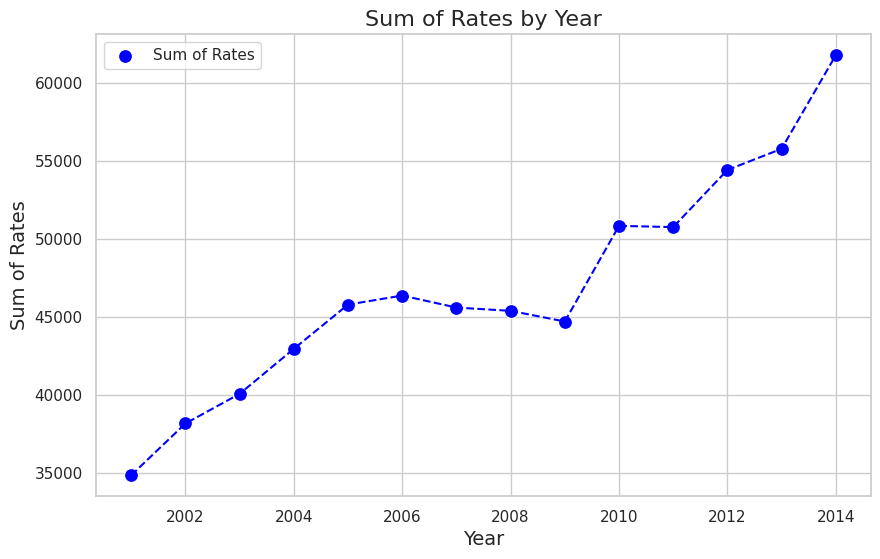

In [7]:
# Group by 'Year' and sum 'Rate'
df_Rate_Year = df.groupby('Year')['Rate'].sum().reset_index()

# Set the style
sns.set(style="whitegrid")

# Create a scatter plot with a trend line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_Rate_Year, x='Year', y='Rate', s=100, color='blue', marker='o', label='Sum of Rates')
sns.lineplot(data=df_Rate_Year, x='Year', y='Rate', color='blue', linestyle='--')

# Add titles and labels
plt.title('Sum of Rates by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Sum of Rates', fontsize=14)

# Show plot
plt.legend()
plt.show()

<ipython-input-8-c51d924484e4>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  county_year_df = df.groupby(['County', 'Year'])[['Rate']].mean().reset_index()


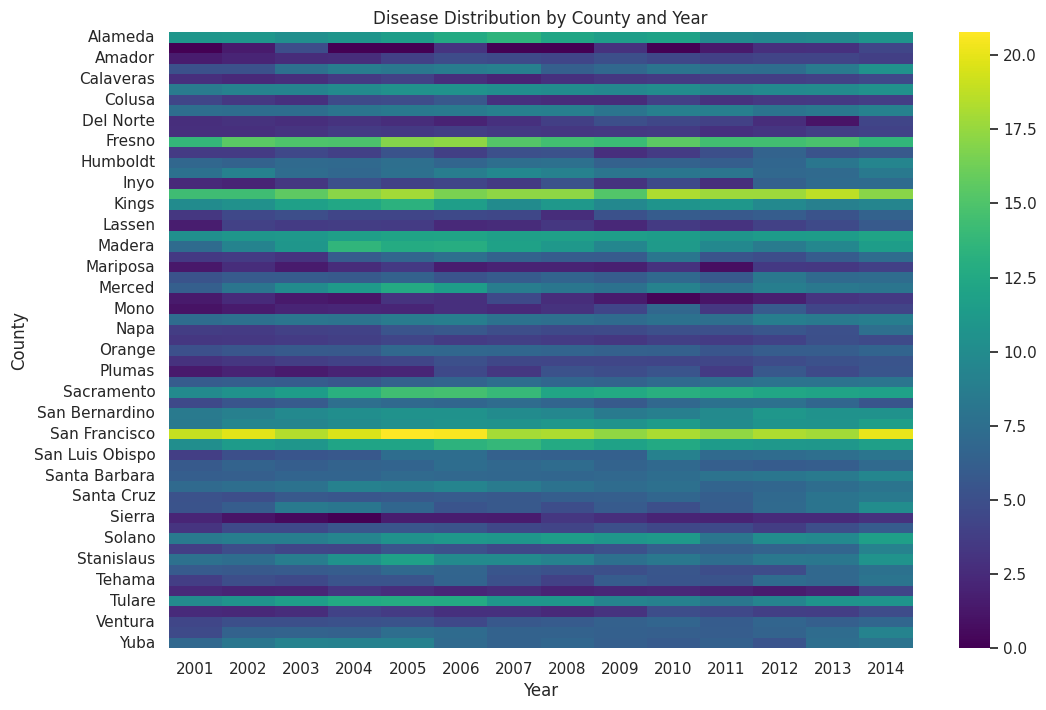

In [8]:
county_year_df = df.groupby(['County', 'Year'])[['Rate']].mean().reset_index()

# Pivot the table to get Rates by Year and County
county_year_pivot = county_year_df.pivot(columns='Year', index='County', values='Rate')

# Heatmap of disease distribution by County and Year
plt.figure(figsize=(12, 8))
sns.heatmap(county_year_pivot, cmap='viridis', annot=False)
plt.title('Disease Distribution by County and Year')
plt.show()

<ipython-input-9-418332ecee37>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_disease_df = df.groupby(['Disease', 'Sex'])['Rate'].sum().reset_index()


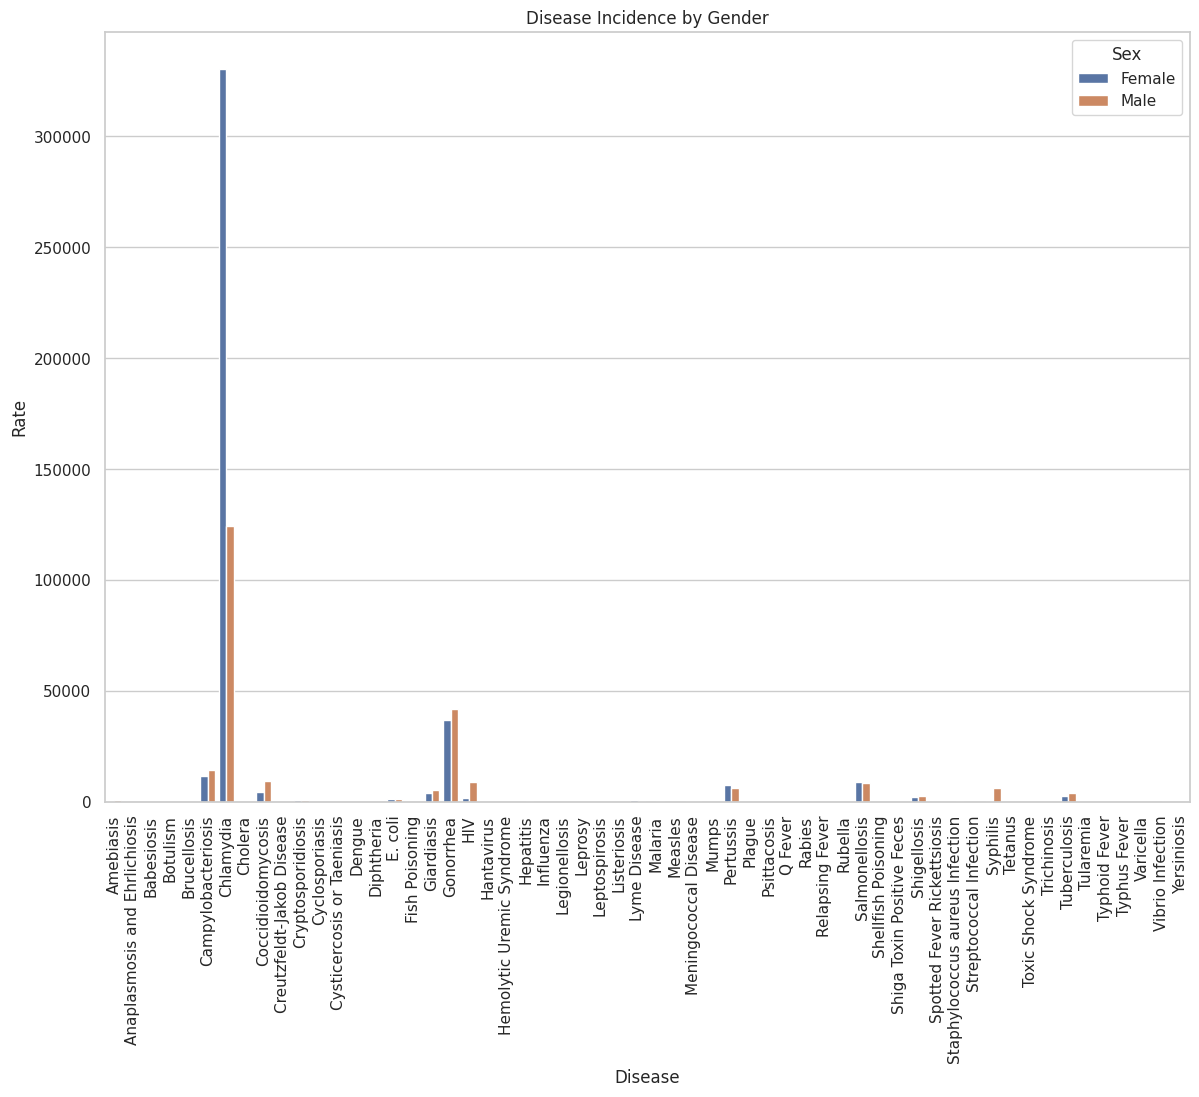

In [9]:
gender_disease_df = df.groupby(['Disease', 'Sex'])['Rate'].sum().reset_index()

# Bar plot of disease incidence by gender
plt.figure(figsize=(14, 10))
sns.barplot(data=gender_disease_df, x='Disease', y='Rate', hue='Sex')
plt.xticks(rotation=90)
plt.title('Disease Incidence by Gender')
plt.show()

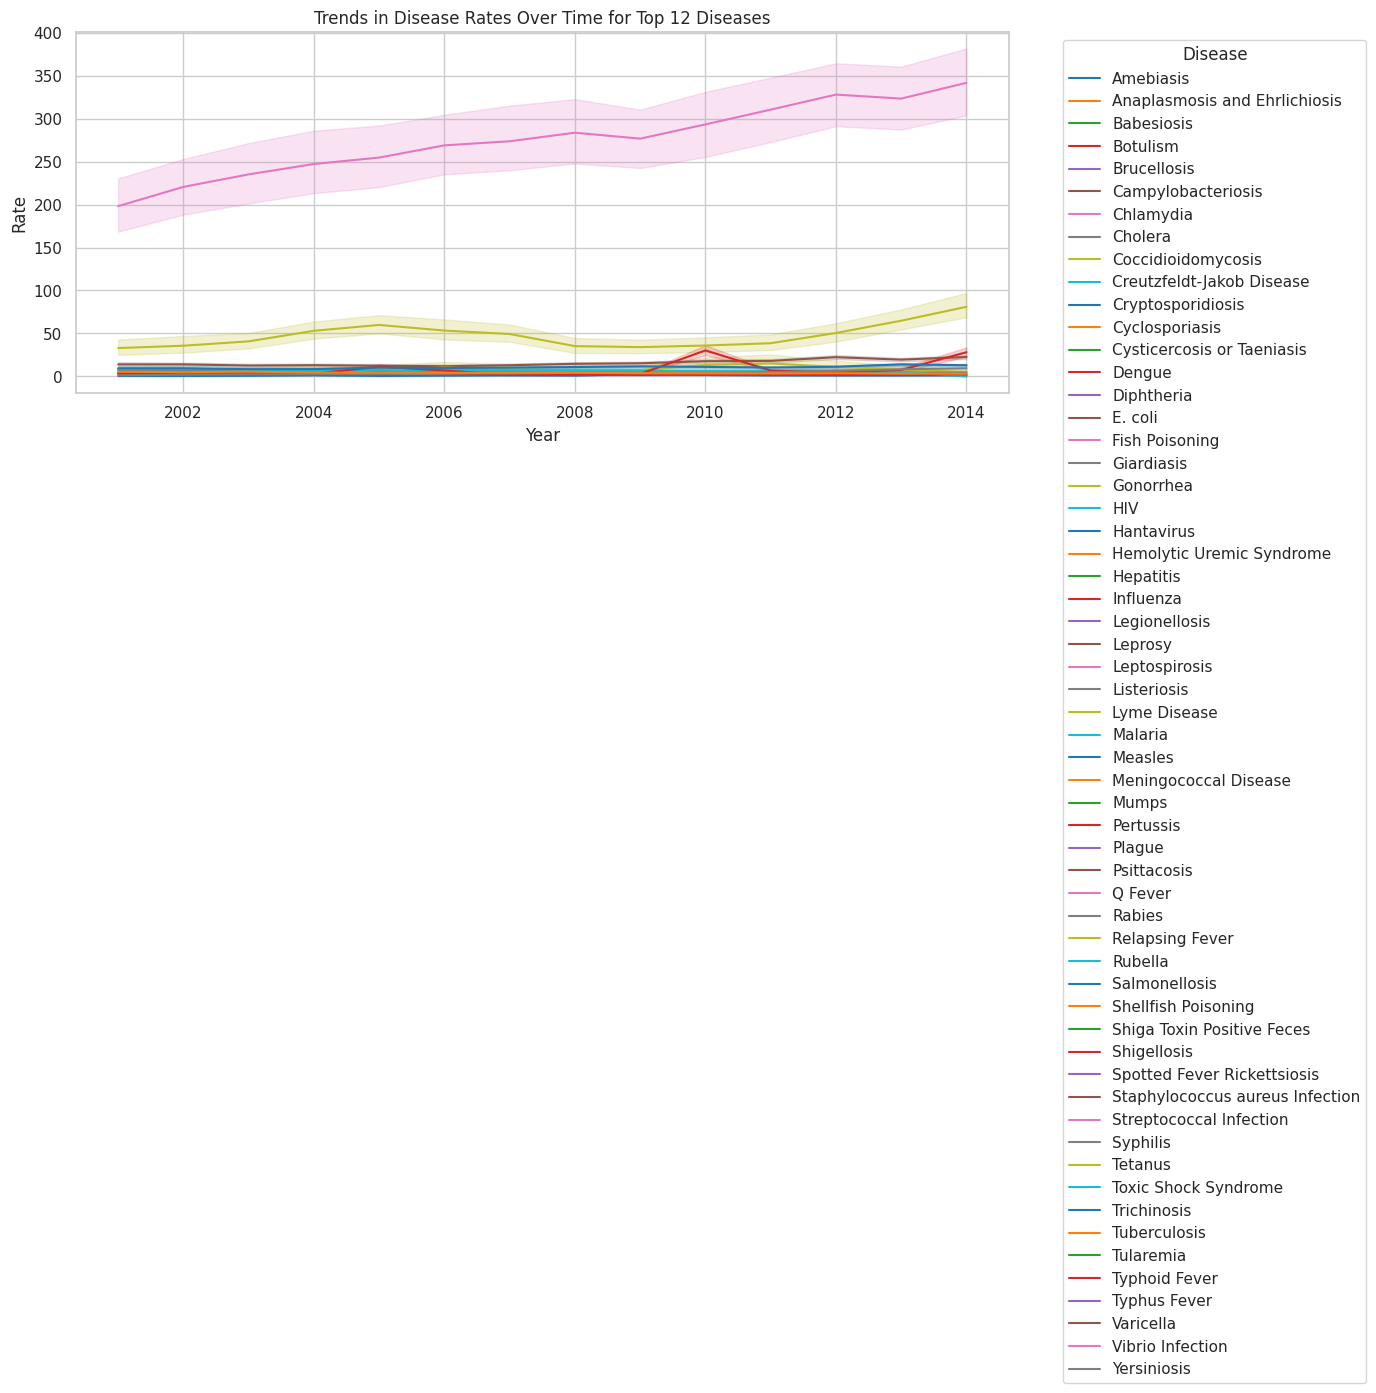

In [10]:
top_12_diseases = df.groupby('Disease', observed=True)['Rate'].mean().nlargest(12).index

# Filter the data for the top 12 diseases
filtered_df = df[df['Disease'].isin(top_12_diseases)]

# Plot the trends using a line plot
plt.figure(figsize=(14, 10))
sns.lineplot(data=filtered_df, x='Year', y='Rate', hue='Disease', palette='tab10')
plt.title('Trends in Disease Rates Over Time for Top 12 Diseases')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.legend(title='Disease', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

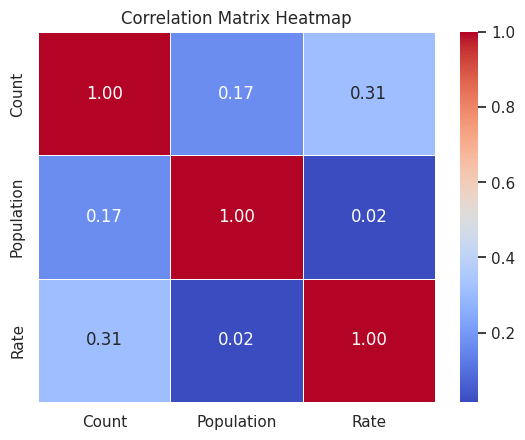

In [11]:
numerical_cols = ["Count", "Population", "Rate"]

# Calculate the correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Draw the heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Add title and labels
plt.title('Correlation Matrix Heatmap')
plt.show()

# Regression Models

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [13]:
categorical_features = ["Disease", "County", "Sex"]
numerical_features = ["Year", "Population", "Rate"]

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(drop='first')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', 'passthrough', numerical_features)
    ]
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Select target variable
y = df["Count"]
X = df.drop("Count", axis=1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 150.6720
Mean Squared Error (MSE): 1161072.8373
R² Score: 0.1184
